# Fitting models to probabilistic selection task data

This notebook lays out a complete model fitting and checking workflow for single and dual learning rate Q-learning models fit to probabilistic selection task (PST) data ([Frank et al., 2004](https://www.science.org/doi/10.1126/science.1102941), [2007](https://www.pnas.org/content/104/41/16311)), using variational approximations to speed things up and make it more reasonable to run this notebook in a short time-frame. Given that they are approximations, results may vary when re-run and may not line up with those from MCMC (i.e., presented in the paper); this notebook is more meant to lay out our approach than to actually replicate the exact results.

### Setup

#### Python dependencies

In [1]:
import os
os.chdir('..')
    # may need to be run initially if working directory is the notebook folder
%load_ext rpy2.ipython

light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

#### Load pstpipeline R package and data

In [2]:
%%R
remotes::install_github(
    "qdercon/pstpipeline", 
    quiet = TRUE,
    upgrade = "always"
)
# cmdstanr::set_cmdstan_path("/root/cmdstan-2.28.1")
cmdstanr::set_cmdstan_path("/home/qd01/cmdstan/cmdstan-2.28.1") 
# extrafont::loadfonts(device = "win", quiet = TRUE) 
    # required on Windows to load additional fonts
options(mc.cores = 4)
    # number of chains to run in parallel

R[write to console]: CmdStan path set to: /home/qd01/cmdstan/cmdstan-2.28.1



In [3]:
%%R
all_res_split <- readRDS("data-raw/all_res_split.RDS")
head(tibble::as_tibble(all_res_split$non_distanced$ppt_info))

## to speed things up further, we can take a subsample
#
# nd_subsample <- pstpipeline::take_subsample(
#     all_res_split$non_distanced, n_ppts = 20
# )
# dis_subsample <- pstpipeline::take_subsample(
#     all_res_split$distanced, n_ppts = 20
# )

# A tibble: 6 × 78
  subjID     sessionID studyID distanced exclusion final_block_AB final_block_CD
  <chr>      <chr>     <chr>   <lgl>         <dbl>          <dbl>          <dbl>
1 a82f81ad2… 6081a559… 608027… FALSE             0           0.5           0.526
2 7516cf0fc… 60816b85… 60801c… FALSE             0           0.55          0.579
3 b5df682d6… 60816cb0… 608025… FALSE             0           0.7           0.55 
4 3c1c4cadb… 60817da7… 608028… FALSE             0           0.5           0.8  
5 8fb49dbc5… 60817829… 608027… FALSE             0           0.9           0.95 
6 12252bc63… 608177c1… 608026… FALSE             0           0.85          0.35 
# … with 71 more variables: final_block_EF <dbl>, total_points <int>,
#   total_time_taken <dbl>, keypress_percent <dbl>, mean_rt <dbl>,
#   digit_span <int>, catch_question_1 <lgl>, catch_question_2 <lgl>,
#   catch_question_3 <lgl>, catch_question_4 <lgl>, sex <chr>, age <int>,
#   gender <chr>, ethnicity <chr>, ses <int>, income

# Q-learning models: background

Model-free reinforcement learning (RL) in the PST is commonly modelled using Q-learning (QL) models. 

In QL models, the weight or Q-value $Q_t(s_t, a_t)$ for a given action $a$ in state $s$ at time $t$ is an estimate of the state-action value, which can in turn be understood as an estimate of the expected sum of future rewards, conditional on that action at time $t$. Q-values are updated trial-by-trial based on prediction errors $\delta_t$:

$Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$

Here, $\alpha$ is the learning rate - in this task, lower values suggest that Q-values are being integrated more over time, while higher values indicate higher sensitivity to recent trials. In bandit tasks such as the PST, it can be shown that selecting a certain action/choice does not affect the transition to future states ([Sutton & Barto, 1998](https://mitpress.mit.edu/books/reinforcement-learning)), and so $\delta_t$ can be given as follows, where $r_t$ is the reward (i.e., positive or negative feedback) obtained at time $t$:

$\delta_t = r_t - Q_t(s_t, a_t)$

Given Luce's choice axiom$^1$, these state-action values can be converted to probabilities using a softmax function for a binary choice:

$P_t(s_t, a_t) = \Large\frac{e^{Q_t(s_t, a_t)*\beta}}{e^{Q_t(s_t, a_t)*\beta}+e^{Q_t(s_t, \bar{a}_t)*\beta}} \normalsize= \Large\frac{1}{1+e^{-\beta*[Q_t(s_t, a_t)-Q_t(s_t, \bar{a}_t)]}}$,

where $\bar{a}_t$ is the alternative (avoided) choice in the pair and $\beta$ is an inverse temperature parameter, lower values of which indicate more deterministic choices. Taking logits, it can be shown that this simplifies to the following:

$logit[P_t(s_t, a_t)] = \beta[Q_t(s_t, a_t) - Q_t(s_t, \bar{a}_t)]$

In all of the following code blocks, the Q-learning models are fitted in a hierarchical Bayesian manner, with uninformative group-level priors on each of the parameters of interest; the trials are iterated over, and the posterior density updated assuming the probability of choosing the chosen option follows a Bernoulli logistic distribution with the chance-of-success parameter = $\beta[Q_t(s_t, a_t) - Q_t(s_t, \bar{a}_t)]$.

$^1$The absence of other symbols from the choices at each trial is assumed to not affect the probability of chosing one over the other.

# Fits to training alone

## Model fits

### 2 learning rates

The primary model of interest for the training phase of the PST is an extended QL model with two learning rates: $\alpha_{gain}$ and $\alpha_{loss}$ ([Frank et al., 2007](https://www.pnas.org/content/104/41/16311)). In this model, two different parameters are used to update the state-action values:

$Q_{t+1}(s_t, a_t) = \left\{ \begin{array}{ll}
Q_t(s_t, a_t) + \alpha_{gain}\delta_t & \text{if } \delta_t \geq  0, \text{ or} \\
Q_t(s_t, a_t) + \alpha_{loss}\delta_t & \text{if } \delta_t < 0 \end{array} \right.$

As $\delta_t < 0$ only when feedback is negative (i.e., $r_t$ = 0), higher $\alpha_{loss}$ values can be interpreted as increased sensitivity to recent negative feedback (and so reduced integration over trials), while higher $\alpha_{gain}$ values suggest increased sensitivity to recent positive feedback.

#### Non-distanced participants

In [4]:
%%R
vb_2a_train_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "2a", exp_part = "training", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a/model_fits/non-distanced"
)
rm(vb_2a_train_nd)

R[write to console]: Compiling Stan program...



Finished in -\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/ 135.2 seconds.


#### Distanced participants

In [5]:
%%R
vb_2a_train_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "2a", exp_part = "training", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"), 
    out_dir = "outputs/cmdstan/2a/model_fits/distanced"
)
rm(vb_2a_train_dis)

R[write to console]: Model executable is up to date!



Finished in  131.7 seconds.


### 1 learning rate

The training phase of the PST may also be adequately modelled with a single learning-rate model, with a simple update equation for the state-action values: $Q_{t+1}(s_t, a_t) = Q_t(s_t, a_t) + \alpha\delta_t$. Evidence that this model fit our data better would indicate that recency effects (as captured by the learning rate $\alpha$) are not conditional on the type of feedback received.

#### Non-distanced participants

In [6]:
%%R
vb_1a_train_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a/model_fits/non-distanced"
)
rm(vb_2a_train_dis)

R[write to console]: Compiling Stan program...



Finished in -\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/- 145.8 seconds.


#### Distanced participants

In [7]:
%%R
vb_1a_train_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a/model_fits/distanced"
)
rm(vb_1a_train_dis)

R[write to console]: Model executable is up to date!



Finished in  200.4 seconds.


### Posterior predictive checks

#### Save predictions for 2-alpha model

In [8]:
%%R
model_nd <- "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_vb_1000.csv"
model_dis <- "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_vb_1000.csv"
obs_nd <- readRDS(
    "outputs/cmdstan/2a/model_fits/non-distanced/fit_pst_training_2a_vb_raw_df.RDS"
)
obs_dis <- readRDS(
    "outputs/cmdstan/2a/model_fits/distanced/fit_pst_training_2a_vb_raw_df.RDS"
)

obs_df_preds_nd_2a <- pstpipeline::get_preds_by_chain(
    model_nd, obs_df = obs_nd, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/2a/predictions_vb/non-distanced",
    memory_save = FALSE
)
obs_df_preds_dis_2a <- pstpipeline::get_preds_by_chain(
    model_dis, obs_df = obs_dis, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/2a/predictions_vb/distanced",
    memory_save = FALSE
)

  |======================================================================| 100%

R[write to console]: Finished in 563.4 seconds.



  |======================================================================| 100%

R[write to console]: Finished in 530.6 seconds.



#### Save predictions for 1-alpha model

In [9]:
%%R
model_nd <- "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_vb_1000.csv"
model_dis <- "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_vb_1000.csv"
obs_nd <- readRDS(
    "outputs/cmdstan/1a/model_fits/non-distanced/fit_pst_training_1a_vb_raw_df.RDS"
)
obs_dis <- readRDS(
    "outputs/cmdstan/1a/model_fits/distanced/fit_pst_training_1a_vb_raw_df.RDS"
)

obs_df_preds_nd_1a <- pstpipeline::get_preds_by_chain(
    model_nd, obs_df = obs_nd, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/1a/predictions_vb/non-distanced",
    memory_save = FALSE
)
obs_df_preds_dis_1a <- pstpipeline::get_preds_by_chain(
    model_dis, obs_df = obs_dis, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/1a/predictions_vb/distanced",
    memory_save = FALSE
)

  |======================================================================| 100%

R[write to console]: Finished in 557.7 seconds.



  |======================================================================| 100%

R[write to console]: Finished in 497.7 seconds.



#### Plot predictions against observed training data

In [10]:
%%R
obs_df_preds <- list()
obs_df_preds$nd_2a <- obs_df_preds$dis_2a <- obs_df_preds$nd_1a <- obs_df_preds$dis_1a <- list()
obs_df_preds$nd_2a$indiv_obs_df <- readRDS("outputs/cmdstan/2a/predictions_vb/non-distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$nd_2a$trial_obs_df <- readRDS("outputs/cmdstan/2a/predictions_vb/non-distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$dis_2a$indiv_obs_df <- readRDS("outputs/cmdstan/2a/predictions_vb/distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$dis_2a$trial_obs_df <- readRDS("outputs/cmdstan/2a/predictions_vb/distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$nd_1a$indiv_obs_df <- readRDS("outputs/cmdstan/1a/predictions_vb/non-distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$nd_1a$trial_obs_df <- readRDS("outputs/cmdstan/1a/predictions_vb/non-distanced/trial_block_avg_hdi_ppcs_df.RDS")
obs_df_preds$dis_1a$indiv_obs_df <- readRDS("outputs/cmdstan/1a/predictions_vb/distanced/indiv_obs_sum_ppcs_df.RDS")
obs_df_preds$dis_1a$trial_obs_df <- readRDS("outputs/cmdstan/1a/predictions_vb/distanced/trial_block_avg_hdi_ppcs_df.RDS")

In [11]:
%%R
grp_names <- c("nd_2a", "nd_1a", "dis_2a", "dis_1a")
grp_titles <- c("Non distanced (2-alpha)", "Non-distanced (1-alpha)",
                "Distanced (2-alpha)", "Distanced (1-alpha)")
pred_plt_list <- vector("list", 3)
pred_plt_list$cum_prob <- pred_plt_list$diffs <- pred_plt_list$indiv_pstrs <- list()

for (grp in grp_names) {
    pred_plts <- pstpipeline::plot_ppc(
        train_indiv = list(obs_df_preds[[grp]]$indiv_obs_df, c(20, 120), c(20, 120)),
        train_trials = list(obs_df_preds[[grp]]$trial_obs_df, "all_trials"),
        group_title = grp_titles[which(grp_names == grp)], font = "Open Sans", 
        font_size = 11
    )
    pred_plt_list$cum_prob[[grp]] <- pred_plts[[1]]
    pred_plt_list$diffs[[grp]] <- pred_plts[[2]]
    pred_plt_list$indiv_pstrs[[grp]] <- pred_plts[[3]]    
}

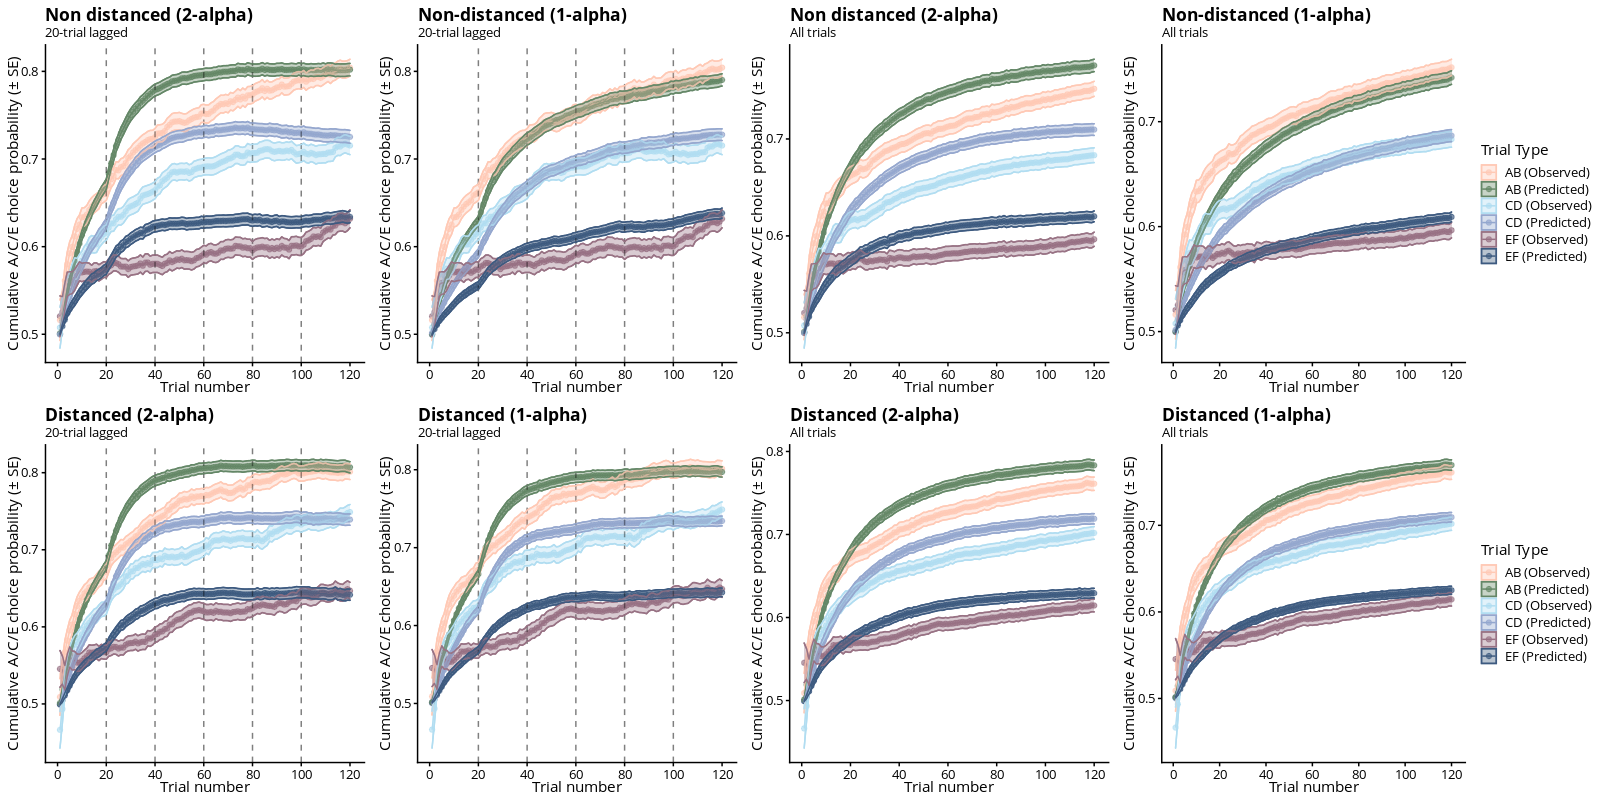

In [12]:
%%R -w 16 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$cum_prob[[1]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[2]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[1]][[2]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[2]][[2]],
    pred_plt_list$cum_prob[[3]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[4]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[3]][[2]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$cum_prob[[4]][[2]],
    nrow = 2,
    ncol = 4,
    rel_widths = c(1,1,1,1.3)
)

These plots show the choice probabilities predicted from the model (i.e., $\frac{\sum_{1}^{n}{choice}}{n}$, where choice = 1 or 0, and n is the total number of posterior draws), plotted against the observed choice probabilities.

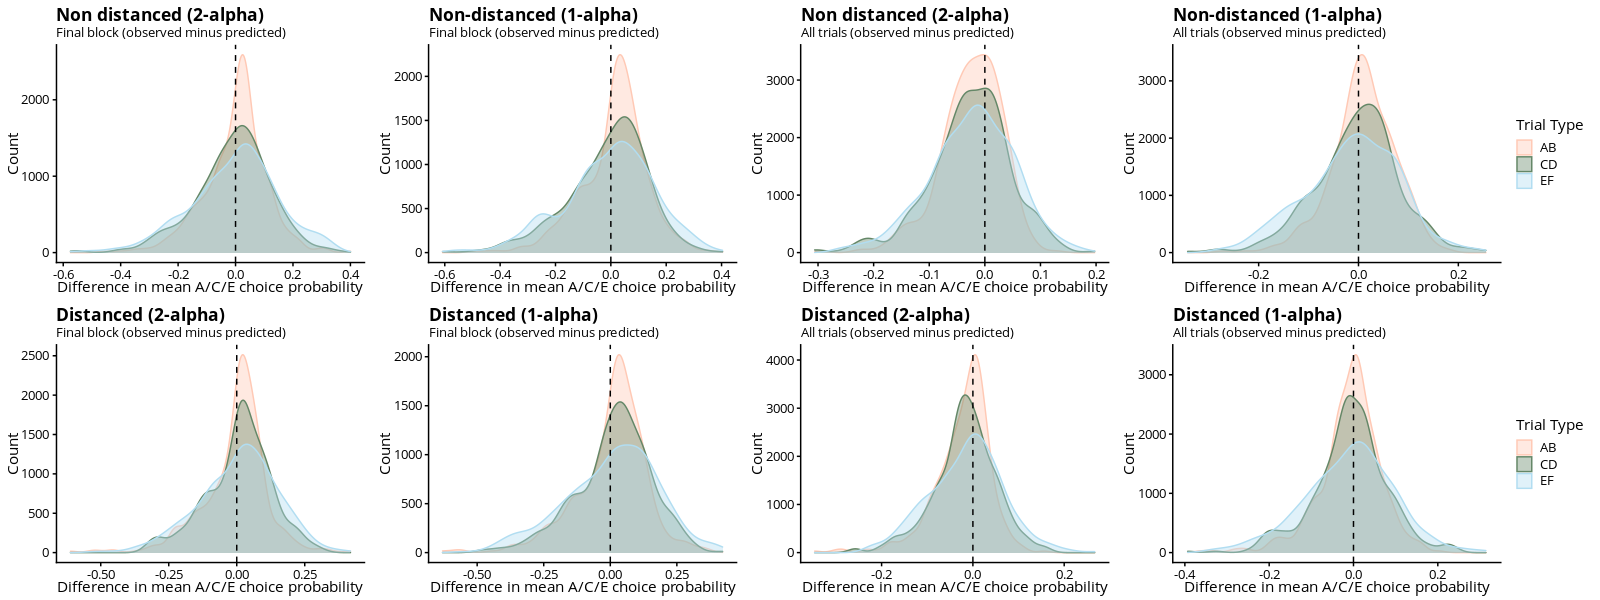

In [13]:
%%R -w 16 -h 6 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$diffs[[1]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[2]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[1]][[2]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[2]][[2]],
    pred_plt_list$diffs[[3]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[4]][[1]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[3]][[2]] + ggplot2::theme(legend.position = "none"),
    pred_plt_list$diffs[[4]][[2]],
    nrow = 2,
    ncol = 4,
    rel_widths = c(1,1,1,1.3)
)

These plots show the distributions of differences between the mean observed choice and the mean predicted choice for each trial type, over all trials and the final block (i.e., last 20 trials).

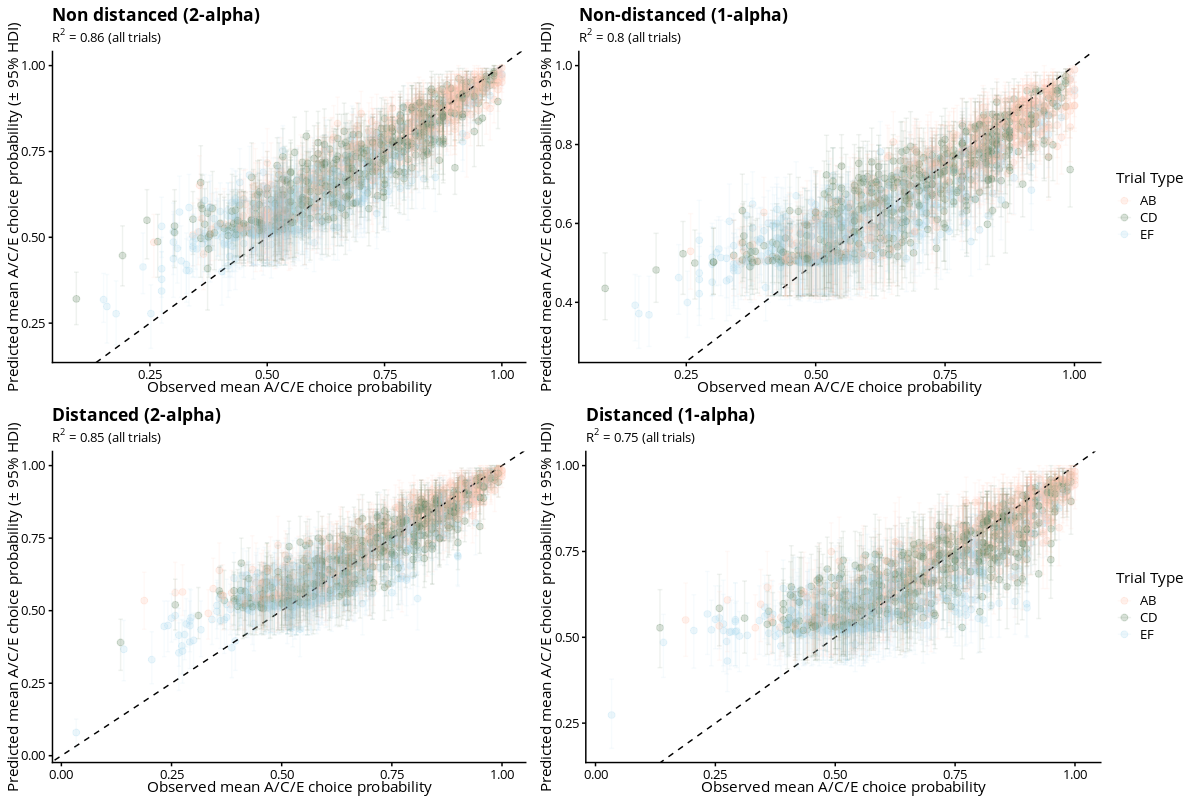

In [14]:
%%R -w 12 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list$indiv_pstrs[[1]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$indiv_pstrs[[2]][[1]],
    pred_plt_list$indiv_pstrs[[3]][[1]] + ggplot2::theme(legend.position="none"),
    pred_plt_list$indiv_pstrs[[4]][[1]],
    ncol = 2,
    rel_widths = c(1,1.25)
)

These plots show the posterior means and 95% HDIs for the number of choices of each type over the whole task, across all posterior draws, plotted against the observed overall choice probabilities for each individual.

In [15]:
%%R
# clear all objects except raw data
rm(list = setdiff(ls(), "all_res_split"))

### Parameter recovery

A useful property of generative models is that it is possible to simulate data from them. Parameter recovery refers to a three-step process: simulating data from a model from a set of (known) parameter values, fitting the models to these simulated data, and then checking whether the fitted parameters are close to those that went in originally. Here, we sample from a gamma distribution (i.e., positively skewed, bounded by 0) for the alphas, and from a Normal distribution for the beta parameter.

In [16]:
%%R
dir.create(file.path("outputs/cmdstan/2a/model_fits/simulated_data"))
dir.create(file.path("outputs/cmdstan/1a/model_fits/simulated_data"))

train_sim_2a <- pstpipeline::simulate_QL(
    sample_size = 100, 
    alpha_pos_dens = c(shape = 2, scale = 0.1),
    alpha_neg_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
train_sim_1a <- pstpipeline::simulate_QL(
    sample_size = 100,
    gain_loss = FALSE,
    alpha_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
saveRDS(train_sim_2a, "outputs/cmdstan/2a/model_fits/simulated_data/training_2a_sim_100ppt.RDS")
saveRDS(train_sim_1a, "outputs/cmdstan/1a/model_fits/simulated_data/training_1a_sim_100ppt.RDS")

  |======================================================================| 100%

In [17]:
%%R
vb_2a_train_sim <- pstpipeline::fit_learning_model(
    train_sim_2a$sim, model = "2a", exp_part = "training",
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a/model_fits/simulated_data", 
    par_recovery = TRUE
);
rm(vb_2a_train_sim)

R[write to console]: Model executable is up to date!



Finished in  42.0 seconds.


In [18]:
%%R
vb_1a_train_sim <- pstpipeline::fit_learning_model(
    train_sim_1a$sim, model = "1a", exp_part = "training", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a/model_fits/simulated_data", 
    par_recovery = TRUE
);
rm(vb_1a_train_sim)

R[write to console]: Model executable is up to date!



Finished in  30.1 seconds.


#### 2-alpha model fit to training alone

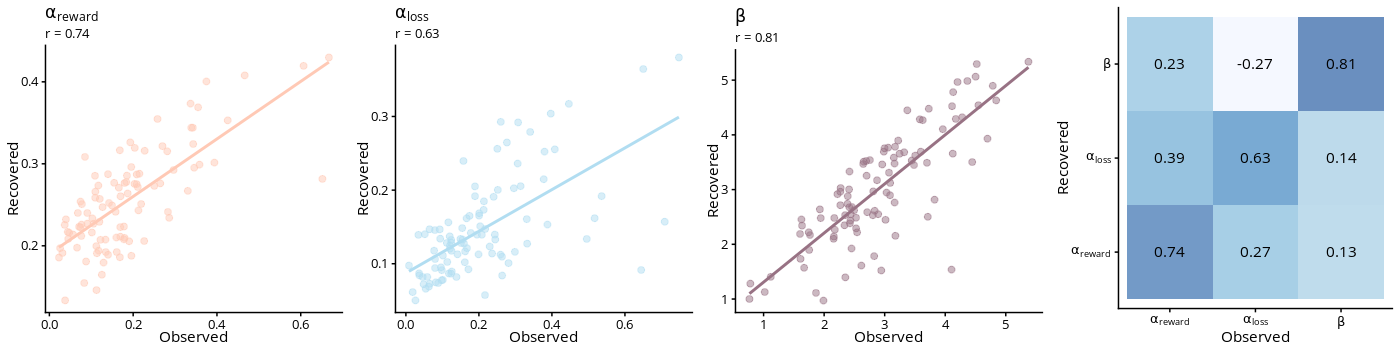

In [19]:
%%R -i light_pal -w 14 -h 3.5 --units in -r 100
sim_pst_training_2a <- readRDS(
    "outputs/cmdstan/2a/model_fits/simulated_data/training_2a_sim_100ppt.RDS"
)
sim_training_2a_fitted <- readRDS(
    "outputs/cmdstan/2a/model_fits/simulated_data/fit_pst_training_2a_vb_summary.RDS"
)

pstpipeline::plot_recovery(
    sim_pst_training_2a$pars, sim_training_2a_fitted, alpha_par_nms = c("reward", "loss"), 
    pal = light_pal, font = "Open Sans"
)

#### 1-alpha model fit to training alone

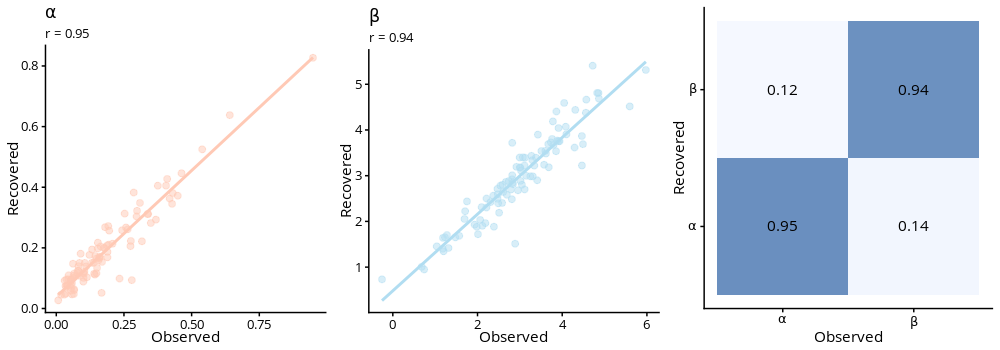

In [20]:
%%R -i light_pal -w 10 -h 3.5 --units in -r 100
sim_pst_training_1a <- readRDS(
    "outputs/cmdstan/1a/model_fits/simulated_data/training_1a_sim_100ppt.RDS"
)
sim_training_1a_fitted <- readRDS(
    "outputs/cmdstan/1a/model_fits/simulated_data/fit_pst_training_1a_vb_summary.RDS"
)

pstpipeline::plot_recovery(
    sim_pst_training_1a$pars, sim_training_1a_fitted, pal = light_pal, font = "Open Sans"
)

In [21]:
%%R
# clear all objects except raw data + free up memory
rm(list = setdiff(ls(), "all_res_split"))
invisible(gc())

# Fits to training plus test

The aim for models including test data is similar to that for those fit to training alone. However, instead of trying to find parameter values which best explain each individual's choices throughout training, we instead wish to find those that explain their test phase choices. Of course, during the test phase, there is no feedback; as such, the test parameters can be thought of as the learning rate / inverse temperature at the end of training which best fit the subsequent test choices: these are assumed to be fixed in the test phase. In practical terms, this means that the models are identical to those fitted to training data, except that at each iteration the posterior density is *also* incremented based on the test choices.

In mathematical terms this means that the probability of choosing one option over another in the test phase is simply given by the following,

$P_t^{test}(s_t, a_t) = \Large\frac{1}{1+e^{-\beta'*[Q_{final}(s_t, a_t)-Q_{final}(s_t, \bar{a}_t)]}}$

where $\beta'$ and $Q_{final}$ correspond to the inverse temperature parameter and Q-values at the end of training respectively.

### 2 learning rates

#### Non-distanced participants

In [22]:
%%R
vb_2a_test_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "2a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a_test/model_fits/non-distanced"
)
rm(vb_2a_test_nd)

R[write to console]: Compiling Stan program...



Finished in -\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 108.6 seconds.


#### Distanced participants

In [23]:
%%R
vb_2a_test_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "2a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"), 
    out_dir = "outputs/cmdstan/2a_test/model_fits/distanced"
)
rm(vb_2a_test_dis)

R[write to console]: Model executable is up to date!



Finished in  109.6 seconds.


### 1 learning rate

#### Non-distanced participants

In [24]:
%%R
vb_1a_test_nd <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a_test/model_fits/non-distanced"
)
rm(vb_1a_test_nd)

R[write to console]: Compiling Stan program...



Finished in -\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/ 102.7 seconds.


#### Distanced participants

In [25]:
%%R
vb_1a_test_dis <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a_test/model_fits/distanced"
);
rm(vb_1a_test_dis)

R[write to console]: Model executable is up to date!



Finished in  111.6 seconds.


### Posterior predictive checks

#### Load predictions for 2-alpha test data model

In [26]:
%%R
model_nd_test <- "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_vb_1000.csv"
model_dis_test <- "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_vb_1000.csv"
obs_nd_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/non-distanced/fit_pst_test_2a_vb_raw_df.RDS"
)
obs_dis_test <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/distanced/fit_pst_test_2a_vb_raw_df.RDS"
)

obs_df_preds_nd_2a_test <- pstpipeline::get_preds_by_chain(
    model_nd_test, obs_df = obs_nd_test, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/2a_test/predictions_vb/non-distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)
obs_df_preds_dis_2a_test <- pstpipeline::get_preds_by_chain(
    model_dis_test, obs_df = obs_dis_test, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/2a_test/predictions_vb/distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)

  |======================================================================| 100%

R[write to console]: Finished in 237.3 seconds.



  |======================================================================| 100%

R[write to console]: Finished in 213.3 seconds.



#### Load predictions for 1-alpha model

In [27]:
%%R
model_nd_test <- "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_vb_1000.csv"
model_dis_test <- "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_vb_1000.csv"
obs_nd_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/non-distanced/fit_pst_test_1a_vb_raw_df.RDS"
)
obs_dis_test <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/distanced/fit_pst_test_1a_vb_raw_df.RDS"
)

obs_df_preds_nd_1a <- pstpipeline::get_preds_by_chain(
    model_nd_test, obs_df = obs_nd_test, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/1a_test/predictions_vb/non-distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)
obs_df_preds_dis_1a <- pstpipeline::get_preds_by_chain(
    model_dis_test, obs_df = obs_dis_test, n_draws_chain = 1000, 
    save_dir = "outputs/cmdstan/1a_test/predictions_vb/distanced",
    test = TRUE, prefix = "test_", memory_save = FALSE
)

  |======================================================================| 100%

R[write to console]: Finished in 233.9 seconds.



  |======================================================================| 100%

R[write to console]: Finished in 210.5 seconds.



#### Plot predictions against observed test data

In [28]:
%%R
obs_df_preds_test <- list()
obs_df_preds_test$dis_1a <- obs_df_preds_test$nd_1a <- list()
obs_df_preds_test$dis_2a <- obs_df_preds_test$nd_2a <- list()
obs_df_preds_test$nd_2a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions_vb/non-distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$nd_2a$trial_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions_vb/non-distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$dis_2a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions_vb/distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$dis_2a$trial_obs_df <- readRDS(
    "outputs/cmdstan/2a_test/predictions_vb/distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$nd_1a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions_vb/non-distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$nd_1a$trial_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions_vb/non-distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)
obs_df_preds_test$dis_1a$indiv_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions_vb/distanced/test_indiv_obs_sum_ppcs_df.RDS"
)
obs_df_preds_test$dis_1a$trial_obs_df <- readRDS(
    "outputs/cmdstan/1a_test/predictions_vb/distanced/test_trial_block_avg_hdi_ppcs_df.RDS"
)

In [29]:
%%R
grp_names <- c("nd_2a", "nd_1a", "dis_2a", "dis_1a")
grp_titles <- c("Non distanced (2-alpha)", "Non-distanced (1-alpha)",
                "Distanced (2-alpha)", "Distanced (1-alpha)")
pred_plt_list_test <- vector("list", 4)

for (grp in grp_names) {
    num <- which(grp_names == grp)
    pred_plts <- pstpipeline::plot_ppc(
        test_perf = list(obs_df_preds_test[[grp]]$indiv_obs_df, 
                         list(), list(c("all"), "individual")),
        group_title = grp_titles[num], 
        font = "Open Sans", font_size = 11,
        legend_pos = ifelse((num %% 2) != 0, "none", "right")
    )
    pred_plt_list_test[[grp]] <- pred_plts[[1]]
}

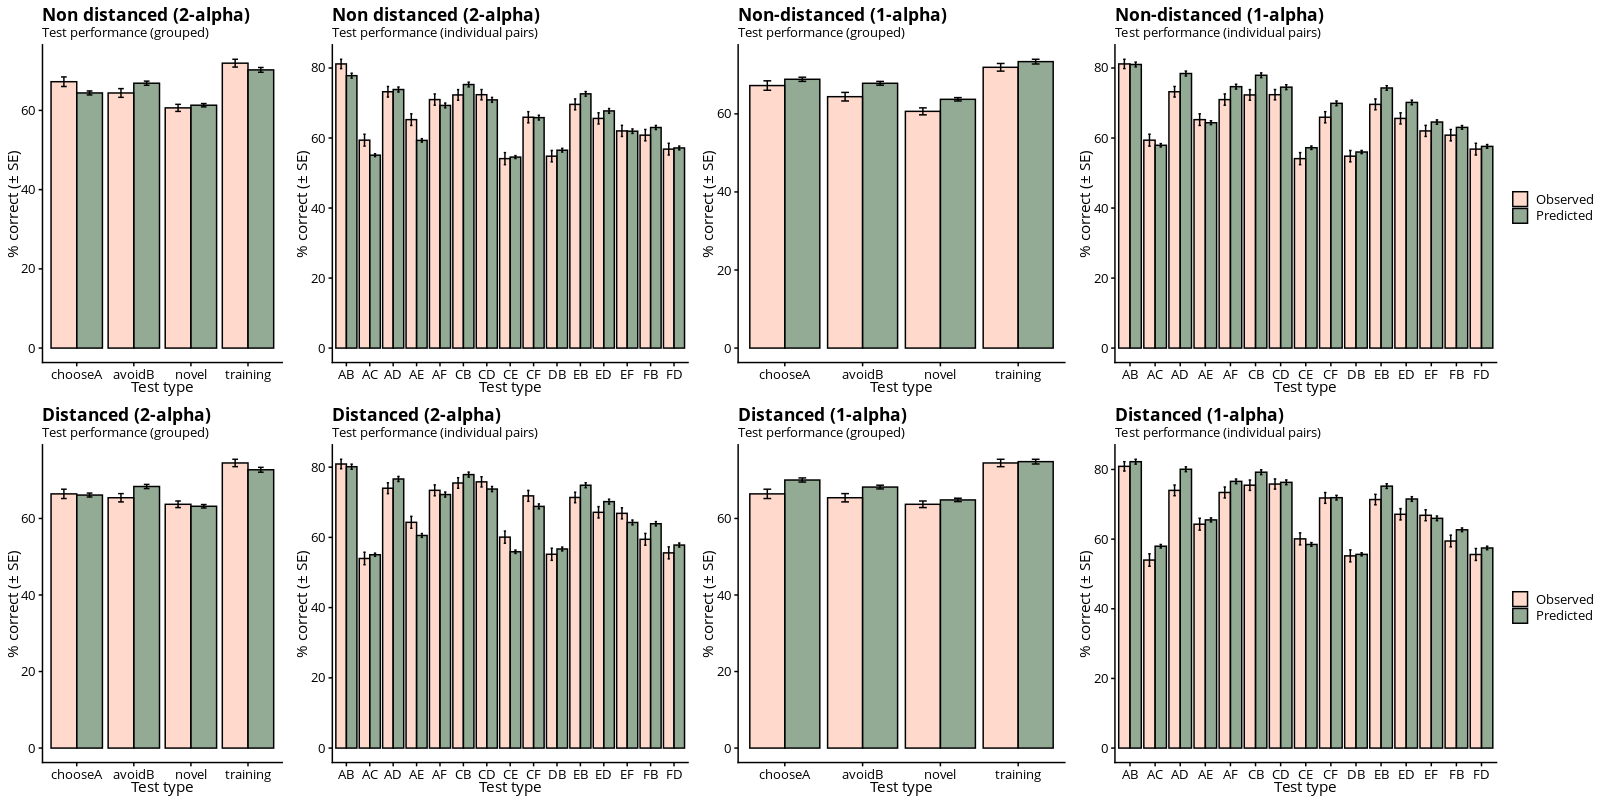

In [30]:
%%R -w 16 -h 8 --units in -r 100
cowplot::plot_grid(
    pred_plt_list_test$nd_2a,
    pred_plt_list_test$nd_1a,
    pred_plt_list_test$dis_2a,
    pred_plt_list_test$dis_1a,
    nrow = 2,
    ncol = 2,
    rel_widths = c(1,1.3)
)

### Parameter recovery

Finally, we repeat the parameter recovery for the training plus test data.

In [31]:
%%R
test_sim_2a <- pstpipeline::simulate_QL(
    sample_size = 100, 
    test = TRUE,
    alpha_pos_dens = c(shape = 2, scale = 0.1),
    alpha_neg_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
test_sim_1a <- pstpipeline::simulate_QL(
    sample_size = 100,
    test = TRUE,
    gain_loss = FALSE,
    alpha_dens = c(shape = 2, scale = 0.1),
    beta_dens = c(mean = 3, sd = 1)
)
saveRDS(test_sim_2a, "outputs/cmdstan/2a_test/model_fits/simulated_data/test_2a_sim_100ppt.RDS")
saveRDS(test_sim_1a, "outputs/cmdstan/1a_test/model_fits/simulated_data/test_1a_sim_100ppt.RDS")

  |======================================================================| 100%

In [32]:
%%R
vb_2a_test_sim <- pstpipeline::fit_learning_model(
    test_sim_2a$sim, model = "2a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/2a_test/model_fits/simulated_data", 
    par_recovery = TRUE
)
rm(vb_2a_test_sim)

R[write to console]: Model executable is up to date!



Finished in  19.6 seconds.


In [33]:
%%R
vb_1a_test_sim <- pstpipeline::fit_learning_model(
    test_sim_1a$sim, model = "1a", exp_part = "test", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, refresh = 0,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/1a_test/model_fits/simulated_data", 
    par_recovery = TRUE
)
rm(vb_1a_test_sim)

R[write to console]: Model executable is up to date!



Finished in  35.2 seconds.


#### 2-alpha model fit to training plus test

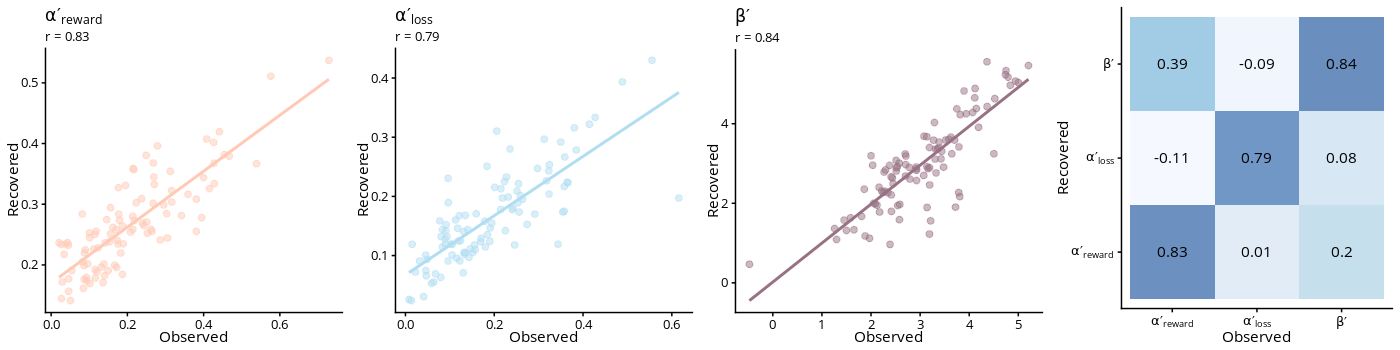

In [34]:
%%R -i light_pal -w 14 -h 3.5 --units in -r 100
sim_pst_training_2a <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/simulated_data/test_2a_sim_100ppt.RDS"
)
sim_training_2a_fitted <- readRDS(
    "outputs/cmdstan/2a_test/model_fits/simulated_data/fit_pst_test_2a_vb_summary.RDS"
)

pstpipeline::plot_recovery(
    sim_pst_training_2a$pars, sim_training_2a_fitted, test = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = light_pal, font = "Open Sans"
)

#### 1-alpha model fit to training plus test

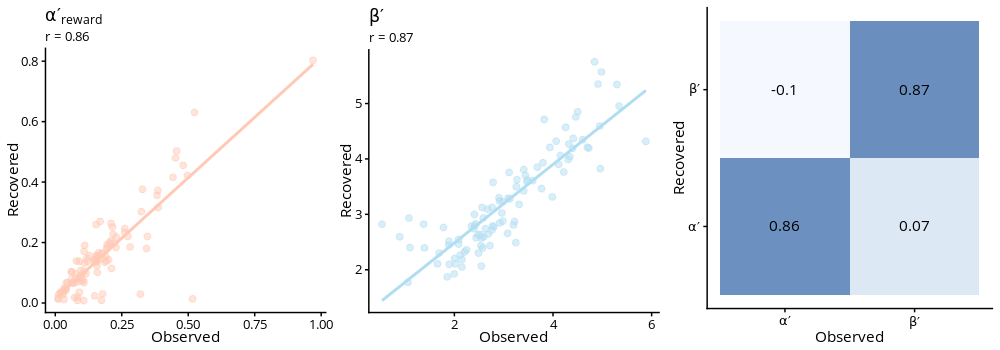

In [35]:
%%R -i light_pal -w 10 -h 3.5 --units in -r 100
sim_pst_training_1a <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/simulated_data/test_1a_sim_100ppt.RDS"
)
sim_training_1a_fitted <- readRDS(
    "outputs/cmdstan/1a_test/model_fits/simulated_data/fit_pst_test_1a_vb_summary.RDS"
)

pstpipeline::plot_recovery(
    sim_pst_training_1a$pars, sim_training_1a_fitted, test = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = light_pal, font = "Open Sans"
)